# <font color='red' face='Times New Roman' size=15>**A Machine Learning-Based QSAR Model for Predicting Toxicity of Commercial Pesticides to** ***Eisenia fetida***</font>

## **The following is an example of building binary QSAR models in the article, due to the author's limited level, there are inevitably flaws in the modeling process, do not blame!**

### The process of building binary classification models for predicting the toxicity of pesticides to *Eisenia fetida* is shown below:

#### The versions of Python packages (except pickle) used in this study are listed below:
|Package|Version|
|:---:|:---:|
|bayesian-optimization|1.4.3|
|imbalanced-learn|0.12.3|
|lightgbm|4.4.0|
|matplotlib|3.9.0|
|mordredcommunity|2.0.6|
|numpy|1.26.4|
|pandas|2.0.0|
|rdkit|2023.9.6|
|scikit-learn|1.5.0|
|seaborn|0.13.2|
|shap|0.45.1|
|xgboost|2.1.0|
#### <font color='red' face='Times New Roman' size=15>**The environment dependencies required to execute this notebook can be quickly installed through the requirements file.**</font>

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from modeling import *  ## customizable function

plt.rcParams["axes.unicode_minus"] = False

#### Imported the dataset, calculated molecular representations; one-hot encode the pesticide formulations because we wanted to know how each formulation affected the toxicity of pesticides to *Eisenia fetida*

##### Abbreviations
|Full name|Breif name|
|:---:|:---:|
|technical material|TC|
|water-dispersible granules|WG|
|emulsifiable concentrate|EC|
|emulsion in water|EW|
|suspension concentrate|SC|
|wettable powder|WP|
|microemulsions|ME|
|water dispersible powder for slurry seed treatment|WS|
|aqueous solution|AS|
|smoke generator|FU|
|microencapsulated powder|CJ|
|capsule suspension|CS|
|oil dispersion|OD|
|effervescent tablet|PP|
|flowable concentrate for seed treatment|SD|
|water soluble granule|SG|
|soluble concentrate|SL|
|water soluble powder|SP|
|technical concentrate|TK|
|granule|GR|

In [2]:
pesticides_data = pd.read_excel(
    "dataset.xlsx", header=0, sheet_name="Binary classification"
)

model_data = compute_mordred(pesticides_data)  ##  compute Mordred descriptors

formulation = pd.get_dummies(
    model_data["Pesticide formulation"], dtype=int
)  ##  convert pesticide formulation to dummy variables
model_data = pd.concat([formulation, model_data], axis=1)
model_data.drop(
    ["Pesticide formulation", "English name", "CAS number"], axis=1, inplace=True
)

model_data

100%|██████████| 573/573 [00:11<00:00, 48.55it/s]


,AS,CJ,CS,EC,EW,FU,GR,ME,OD,PP,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,0,0,0,0,0,0,0,0,0,...,10.433792,76.232991,354.101585,8.636624,1525.0,49.0,144.0,178.0,8.722222,5.694444
1,0,0,0,0,0,0,0,0,0,0,...,9.659440,45.904399,263.881559,18.848683,272.0,25.0,68.0,82.0,7.166667,3.333333
2,0,0,0,1,0,0,0,0,0,0,...,8.448700,38.179718,169.014009,9.389667,139.0,7.0,42.0,40.0,5.923611,2.208333
3,0,0,0,1,0,0,0,0,0,0,...,8.448700,38.179718,169.014009,9.389667,139.0,7.0,42.0,40.0,5.923611,2.208333
4,0,0,0,1,0,0,0,0,0,0,...,8.448700,38.179718,169.014009,9.389667,139.0,7.0,42.0,40.0,5.923611,2.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0,0,0,0,1,0,0,0,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667
569,0,0,0,0,0,0,0,1,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667
570,0,0,0,0,0,0,0,1,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667
571,0,0,0,0,0,0,0,1,0,0,...,10.042771,69.373224,315.100330,8.516225,1003.0,33.0,116.0,136.0,6.868056,4.791667


#### Stratified sampling in the ratio of 8:2 to divide the training and test sets

In [3]:
X_train, X_test, y_train, y_test = data_split(
    df=model_data, label="Toxicity level", test_size=0.2
)

extrainfo_train = X_train.iloc[:, :22].reset_index(
    drop=True
)  ##  The 22 features extracted included soil organic matter content, soil pH and 20 pesticide formulations.

extrainfo_test = X_test.iloc[:, :22].reset_index(drop=True)
# print(extrainfo_train)
# print(extrainfo_test)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

feature_names = X_train.columns.tolist()

#### Distribution of training and test sets

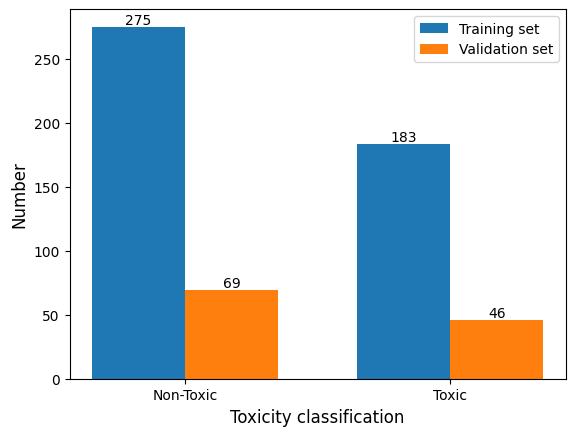

In [4]:
num0 = len(y_train[y_train == 0])
num1 = len(y_train[y_train == 1])

num2 = len(y_test[y_test == 0])
num3 = len(y_test[y_test == 1])

data1 = [num0, num1]
data2 = [num2, num3]
categories = ["Non-Toxic", "Toxic"]
bar_width = 0.35
bar_positions_group1 = np.arange(len(categories))
bar_positions_group2 = bar_positions_group1 + bar_width

plt.figure()
bars1 = plt.bar(bar_positions_group1, data1, width=bar_width, label="Training set")
for bar, data in zip(bars1, data1):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        data,
        ha="center",
        va="bottom",
    )

bars2 = plt.bar(bar_positions_group2, data2, width=bar_width, label="Validation set")
for bar, data in zip(bars2, data2):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        data,
        ha="center",
        va="bottom",
    )

plt.xticks(bar_positions_group1 + bar_width / 2, categories)
plt.xlabel("Toxicity classification", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.show()

#### Use XGBoost to select the 10 most important features

In [4]:
model_select_feature = XGBClassifier(seed=0)
num_features = 10

X_train, X_test, features_selected = feature_selection(
    model_select_feature, num_features, X_train, y_train, X_test
)

print(f"We select {len(features_selected)} features as follows: \n {features_selected}")

We select 10 features as follows: 
          Features
0          ATSC0p
1          ATSC6i
2        AATSC0dv
3          MATS1s
4          GATS2d
5          GATS2s
6           Xc-3d
7       PEOE_VSA9
8          AMID_N
9  TopoShapeIndex


#### Feature Importance given by the XGBoost model

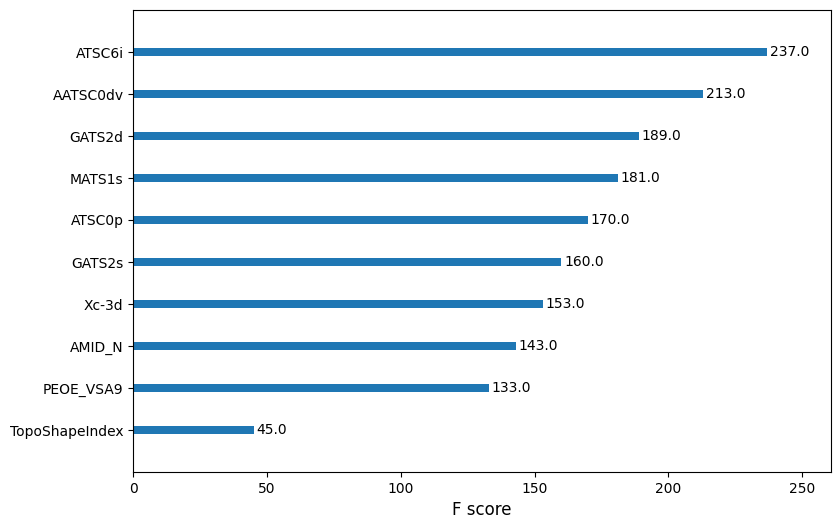

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

plot_importance(
    model_select_feature.fit(X_train, y_train),
    ax=ax,
    ylabel=None,
    title=None,
    grid=False,
)
plt.xlabel("F score", fontsize=12)

plt.show()

#### Evaluate the correlation between these 10 descriptors

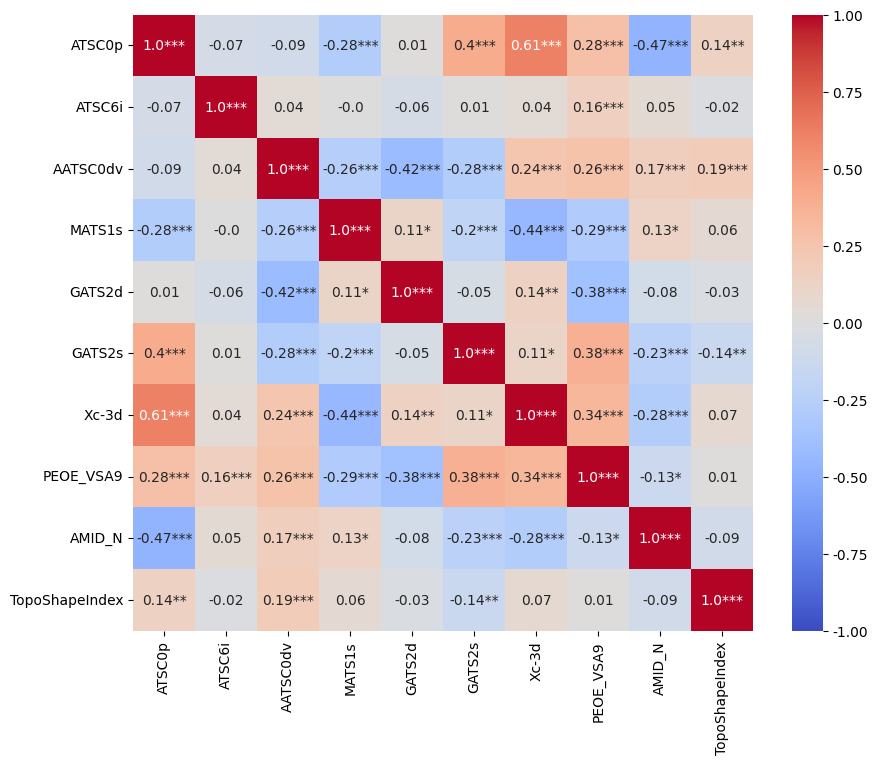

In [7]:
corr_matrix, pval_matrix = calculate_corr_pval(X_train)

annot_matrix = create_annot_matrix(corr_matrix, pval_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=annot_matrix,
    fmt="",
    annot_kws={"size": 10},
)

plt.show()

#### Remove one of the strongly correlated molecular descriptor pairs (Pearson's correlation coefficient greater than 0.8) and merge soil properties and pesticide formulations

In [8]:
X_train = pd.concat([extrainfo_train, X_train], axis=1)
X_test = pd.concat([extrainfo_test, X_test], axis=1)

#### Define the models; build the pipelines

In [9]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

scaler = StandardScaler()

models = [
    LogisticRegression(random_state=0),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(probability=True, random_state=0),
    DecisionTreeClassifier(random_state=0),
    BaggingClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    LGBMClassifier(verbose=-1, random_state=0),
]

modelnames = [
    "Logistic Regression",
    "Linear Discriminant Analysis",
    "Gaussian Naive Bayes",
    "K-nearest Neighbor",
    "Supporting Vector Machine",
    "Decision Tree",
    "Bagging",
    "Random Forest",
    "Gradient Boosting",
    "Light Gradient Boosting Machine",
]

ppls = []

for model in models:  ##  these 5 models need to be scaled before training

    if isinstance(
        model,
        (
            LogisticRegression,
            LinearDiscriminantAnalysis,
            KNeighborsClassifier,
            GaussianNB,
            SVC,
        ),
    ):
        ppl = make_pipeline(scaler, model)
        ppls.append(ppl)
    else:
        ppls.append(model)

#### Train the models with the default hyperparameters and use the test set to evaluate

Logistic Regression's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.73913043 0.7173913  0.73913043 0.65217391 0.69565217
 0.89130435 0.67391304 0.66666667 0.73333333] 

Logistic Regression's mean result of 10-fold cross-validation is 0.727
Logistic Regression's Matthews Correlation Coefficient is 0.445 

Logistic Regression's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        69
           1       0.71      0.59      0.64        46

    accuracy                           0.74       115
   macro avg       0.73      0.71      0.72       115
weighted avg       0.74      0.74      0.73       115



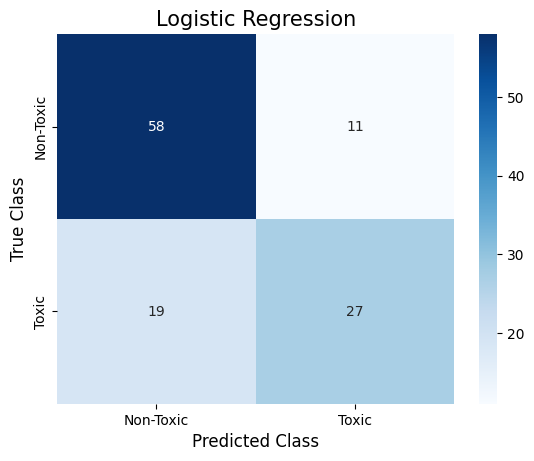

Linear Discriminant Analysis's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.73913043 0.73913043 0.7173913  0.65217391 0.7173913
 0.89130435 0.65217391 0.66666667 0.73333333] 

Linear Discriminant Analysis's mean result of 10-fold cross-validation is 0.729
Linear Discriminant Analysis's Matthews Correlation Coefficient is 0.426 

Linear Discriminant Analysis's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        69
           1       0.70      0.57      0.63        46

    accuracy                           0.73       115
   macro avg       0.72      0.70      0.71       115
weighted avg       0.73      0.73      0.72       115



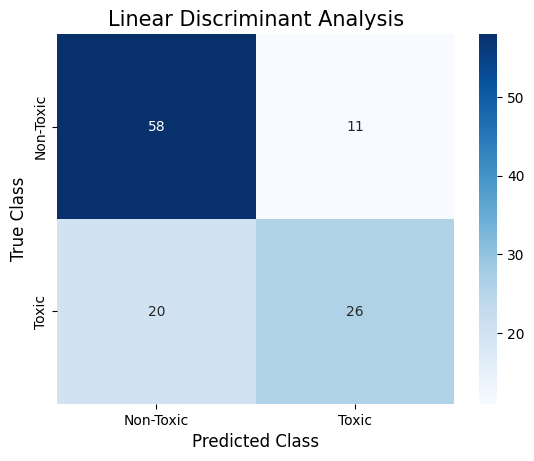

Gaussian Naive Bayes's results of 10-fold cross-validation are as follows: 
 [0.65217391 0.63043478 0.60869565 0.63043478 0.63043478 0.60869565
 0.60869565 0.60869565 0.62222222 0.6       ] 

Gaussian Naive Bayes's mean result of 10-fold cross-validation is 0.62
Gaussian Naive Bayes's Matthews Correlation Coefficient is 0.261 

Gaussian Naive Bayes's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        69
           1       1.00      0.11      0.20        46

    accuracy                           0.64       115
   macro avg       0.81      0.55      0.48       115
weighted avg       0.78      0.64      0.54       115



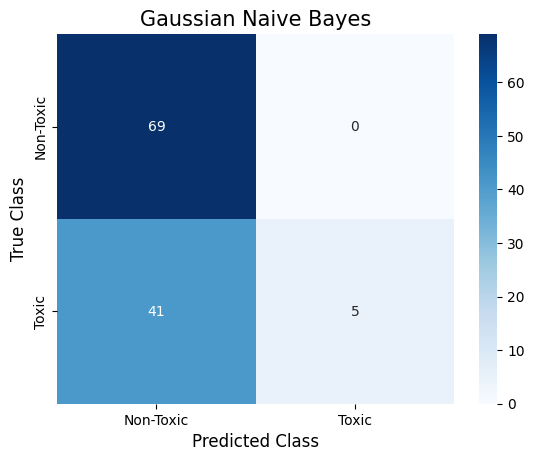

K-nearest Neighbor's results of 10-fold cross-validation are as follows: 
 [0.69565217 0.65217391 0.86956522 0.73913043 0.69565217 0.69565217
 0.82608696 0.7173913  0.66666667 0.68888889] 

K-nearest Neighbor's mean result of 10-fold cross-validation is 0.725
K-nearest Neighbor's Matthews Correlation Coefficient is 0.493 

K-nearest Neighbor's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        69
           1       0.70      0.70      0.70        46

    accuracy                           0.76       115
   macro avg       0.75      0.75      0.75       115
weighted avg       0.76      0.76      0.76       115



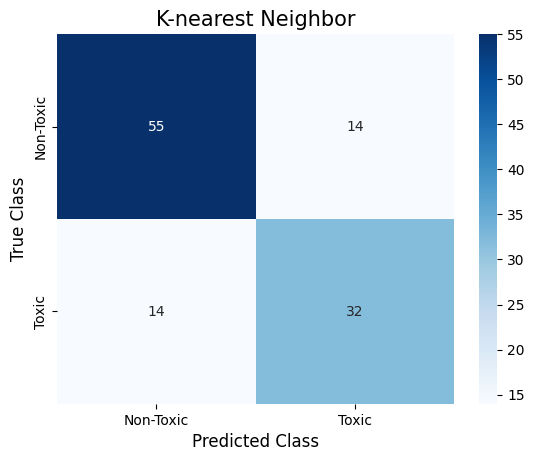

Supporting Vector Machine's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.69565217 0.84782609 0.73913043 0.76086957 0.7173913
 0.82608696 0.73913043 0.6        0.64444444] 

Supporting Vector Machine's mean result of 10-fold cross-validation is 0.733
Supporting Vector Machine's Matthews Correlation Coefficient is 0.502 

Supporting Vector Machine's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        69
           1       0.76      0.61      0.67        46

    accuracy                           0.77       115
   macro avg       0.76      0.74      0.75       115
weighted avg       0.76      0.77      0.76       115



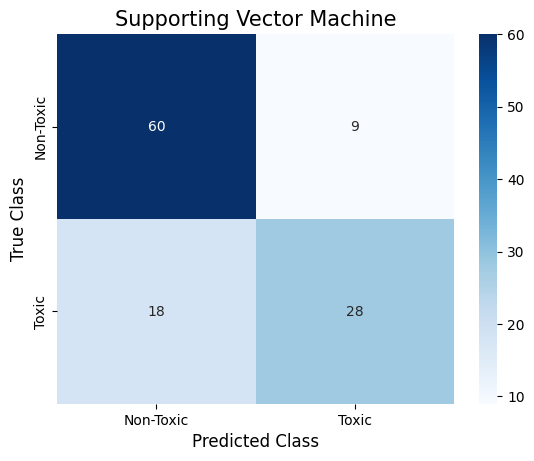

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.80434783 0.84782609 0.7826087  0.7826087  0.73913043 0.7826087
 0.84782609 0.82608696 0.73333333 0.77777778] 

Decision Tree's mean result of 10-fold cross-validation is 0.792
Decision Tree's Matthews Correlation Coefficient is 0.569 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        69
           1       0.73      0.76      0.74        46

    accuracy                           0.79       115
   macro avg       0.78      0.79      0.78       115
weighted avg       0.79      0.79      0.79       115



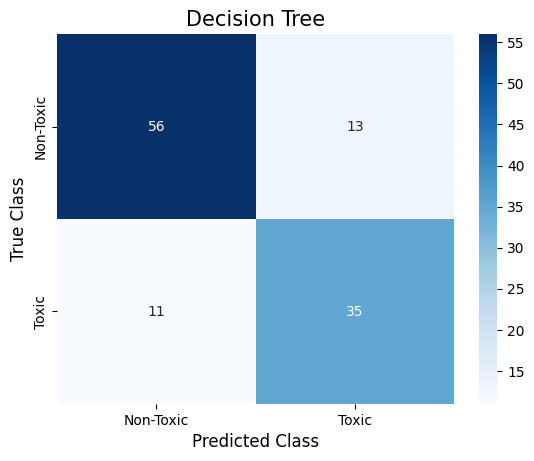

Bagging's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.82608696 0.86956522 0.7826087  0.76086957 0.82608696
 0.82608696 0.84782609 0.73333333 0.8       ] 

Bagging's mean result of 10-fold cross-validation is 0.803
Bagging's Matthews Correlation Coefficient is 0.562 

Bagging's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        69
           1       0.75      0.72      0.73        46

    accuracy                           0.79       115
   macro avg       0.78      0.78      0.78       115
weighted avg       0.79      0.79      0.79       115



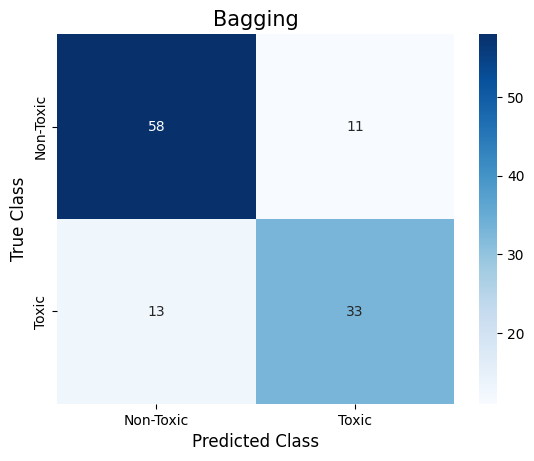

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.76086957 0.95652174 0.76086957 0.7826087  0.80434783
 0.84782609 0.84782609 0.75555556 0.77777778] 

Random Forest's mean result of 10-fold cross-validation is 0.806
Random Forest's Matthews Correlation Coefficient is 0.599 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        69
           1       0.77      0.74      0.76        46

    accuracy                           0.81       115
   macro avg       0.80      0.80      0.80       115
weighted avg       0.81      0.81      0.81       115



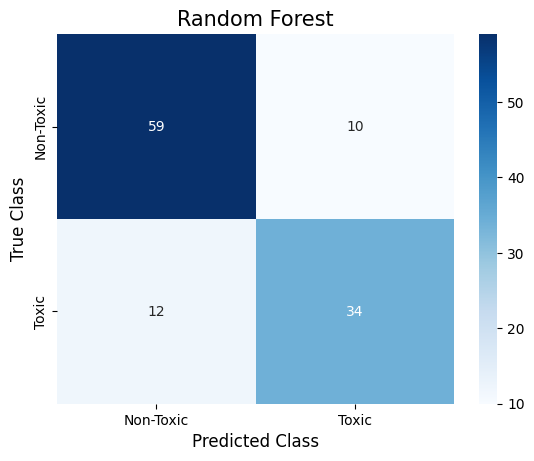

Gradient Boosting's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.7826087  0.91304348 0.76086957 0.82608696 0.84782609
 0.89130435 0.80434783 0.77777778 0.75555556] 

Gradient Boosting's mean result of 10-fold cross-validation is 0.814
Gradient Boosting's Matthews Correlation Coefficient is 0.655 

Gradient Boosting's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        69
           1       0.80      0.78      0.79        46

    accuracy                           0.83       115
   macro avg       0.83      0.83      0.83       115
weighted avg       0.83      0.83      0.83       115



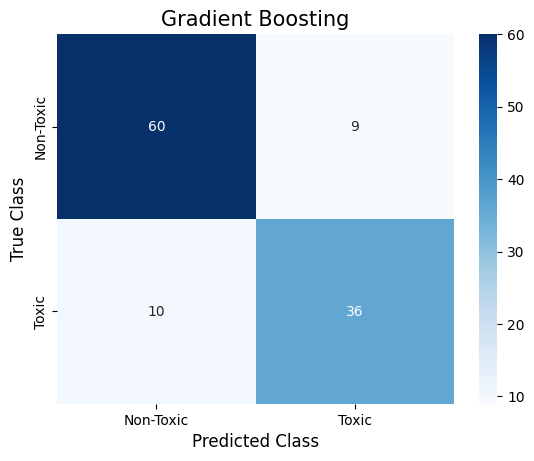

Light Gradient Boosting Machine's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.80434783 0.89130435 0.80434783 0.80434783 0.82608696
 0.86956522 0.84782609 0.75555556 0.82222222] 

Light Gradient Boosting Machine's mean result of 10-fold cross-validation is 0.821
Light Gradient Boosting Machine's Matthews Correlation Coefficient is 0.601 

Light Gradient Boosting Machine's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        69
           1       0.76      0.76      0.76        46

    accuracy                           0.81       115
   macro avg       0.80      0.80      0.80       115
weighted avg       0.81      0.81      0.81       115



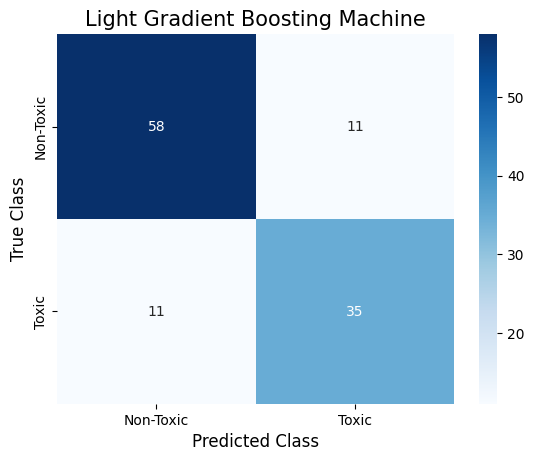

In [18]:
for ppl, name in zip(ppls, modelnames):

    print("=" * 75)
    evaluate_model(ppl, X_train, y_train, X_test, y_test, kf, name)

#### Logistic Regression, Bayesian optimization

In [19]:
def black_box_function1(C, max_iter):

    model = LogisticRegression(
        C=float(C),
        max_iter=int(max_iter),
        solver="liblinear",
        penalty="l2",
        random_state=0,
    )

    ppl = make_pipeline(scaler, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds1 = {"C": (0.1, 5), "max_iter": (50, 500)}

optimizer1 = BayesianOptimization(
    f=black_box_function1, pbounds=pbounds1, verbose=2, random_state=0
)

optimizer1.maximize(init_points=25, n_iter=75)

best_params1 = optimizer1.max["params"]
best_params1["C"] = float("%.3g" % best_params1["C"])
best_params1["max_iter"] = int(best_params1["max_iter"])

print(optimizer1.max)
print(best_params1)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.6175    | 2.789     | 371.8     |
| 2         | 0.622     | 3.054     | 295.2     |
| 3         | 0.6175    | 2.176     | 340.7     |
| 4         | 0.6175    | 2.244     | 451.3     |
| 5         | 0.622     | 4.822     | 222.5     |
| 6         | 0.622     | 3.979     | 288.0     |
| 7         | 0.622     | 2.883     | 466.5     |
| 8         | 0.6192    | 0.4481    | 89.21     |
| 9         | 0.6124    | 0.1991    | 424.7     |
| 10        | 0.622     | 3.913     | 441.5     |
| 11        | 0.622     | 4.895     | 409.6     |
| 12        | 0.6175    | 2.361     | 401.2     |
| 13        | 0.6192    | 0.6795    | 338.0     |
| 14        | 0.6192    | 0.8024    | 475.1     |
| 15        | 0.6175    | 2.657     | 236.6     |
| 16        | 0.6192    | 1.396     | 398.4     |
| 17        | 0.6175    | 2.335     | 305.8     |
| 18        | 0.6124    | 0.1921    | 327.9     |


#### Evaluation

Logistic Regression's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.73913043 0.7173913  0.76086957 0.65217391 0.67391304
 0.89130435 0.67391304 0.66666667 0.73333333] 

Logistic Regression's mean result of 10-fold cross-validation is 0.727
Logistic Regression's Matthews Correlation Coefficient is 0.445 

Logistic Regression's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        69
           1       0.71      0.59      0.64        46

    accuracy                           0.74       115
   macro avg       0.73      0.71      0.72       115
weighted avg       0.74      0.74      0.73       115



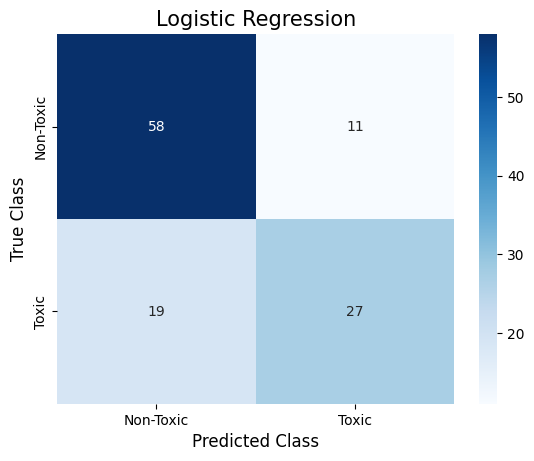

In [20]:
model_1 = LogisticRegression(
    C=best_params1["C"],
    max_iter=best_params1["max_iter"],
    solver="liblinear",
    penalty="l2",
    random_state=0,
)

ppl_1 = make_pipeline(scaler, model_1)

evaluate_model(ppl_1, X_train, y_train, X_test, y_test, kf, name="Logistic Regression")

#### LDA and GNB have fewer hyperparameters, so we do not tuned their hyperparameters

In [21]:
ppl_2 = make_pipeline(scaler, LinearDiscriminantAnalysis())
ppl_3 = make_pipeline(scaler, GaussianNB())

ppl_2.fit(X_train, y_train)
ppl_3.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

#### KNN, Bayesian optimization

In [22]:
def black_box_function4(n_neighbors):

    model = KNeighborsClassifier(
        n_neighbors=int(n_neighbors),
        algorithm="brute",
    )

    ppl = make_pipeline(scaler, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds4 = {"n_neighbors": (1, 100)}

optimizer4 = BayesianOptimization(
    f=black_box_function4,
    pbounds=pbounds4,
    verbose=2,
    random_state=0,
    allow_duplicate_points=True,
)

optimizer4.maximize(init_points=25, n_iter=75)

best_params4 = optimizer4.max["params"]
best_params4["n_neighbors"] = int(best_params4["n_neighbors"])

print(optimizer4.max)
print(best_params4)

|   iter    |  target   | n_neig... |
-------------------------------------
| 1         | 0.2489    | 55.33     |
| 2         | 0.2174    | 71.8      |
| 3         | 0.1896    | 60.67     |
| 4         | 0.2092    | 54.94     |
| 5         | 0.2508    | 42.94     |
| 6         | 0.1974    | 64.94     |
| 7         | 0.2338    | 44.32     |
| 8         | 0.1274    | 89.29     |
| 9         | 0.08211   | 96.4      |
| 10        | 0.2819    | 38.96     |
| 11        | 0.154     | 79.38     |
| 12        | 0.2268    | 53.36     |
| 13        | 0.2183    | 57.24     |
| 14        | 0.09158   | 92.63     |
| 15        | 0.4799    | 8.033     |
| 16        | 0.5318    | 9.626     |
| 17        | 0.6384    | 3.002     |
| 18        | 0.1526    | 83.43     |
| 19        | 0.137     | 78.04     |
| 20        | 0.1349    | 87.13     |
| 21        | 0.09168   | 97.88     |
| 22        | 0.137     | 80.12     |
| 23        | 0.2497    | 46.69     |
| 24        | 0.137     | 78.27     |
| 25        

#### Evaluation

KNN's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.67391304 0.82608696 0.73913043 0.69565217 0.7173913
 0.82608696 0.80434783 0.66666667 0.8       ] 

KNN's mean result of 10-fold cross-validation is 0.753
KNN's Matthews Correlation Coefficient is 0.573 

KNN's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        69
           1       0.72      0.78      0.75        46

    accuracy                           0.79       115
   macro avg       0.78      0.79      0.79       115
weighted avg       0.80      0.79      0.79       115



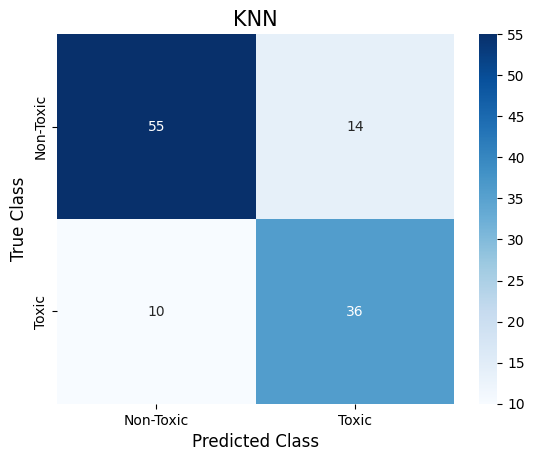

In [23]:
model_4 = KNeighborsClassifier(
    n_neighbors=best_params4["n_neighbors"],
    algorithm="brute",
)

ppl_4 = make_pipeline(scaler, model_4)

evaluate_model(ppl_4, X_train, y_train, X_test, y_test, kf, name="KNN")

#### SVC, Bayesian optimization

In [10]:
def black_box_function5(C, gamma):

    model = SVC(
        C=float(C), gamma=float(gamma), kernel="rbf", probability=True, random_state=0
    )

    ppl = make_pipeline(scaler, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds5 = {"C": (1e-3, 10), "gamma": (1e-3, 10)}

optimizer5 = BayesianOptimization(
    f=black_box_function5, pbounds=pbounds5, verbose=2, random_state=0
)

optimizer5.maximize(init_points=25, n_iter=75)

best_params5 = optimizer5.max["params"]

best_params5["C"] = float("%.3g" % best_params5["C"])
best_params5["gamma"] = float("%.3g" % best_params5["gamma"])

print(optimizer5.max)
print(best_params5)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.0       | 5.489     | 7.152     |
| 2         | 0.0       | 6.028     | 5.449     |
| 3         | 0.0       | 4.237     | 6.459     |
| 4         | 0.0       | 4.376     | 8.918     |
| 5         | 0.03957   | 9.637     | 3.835     |
| 6         | 0.0       | 7.917     | 5.289     |
| 7         | 0.0       | 5.681     | 9.256     |
| 8         | 0.06105   | 0.7113    | 0.8722    |
| 9         | 0.0       | 0.2032    | 8.326     |
| 10        | 0.0       | 7.782     | 8.7       |
| 11        | 0.0       | 9.786     | 7.992     |
| 12        | 0.0       | 4.615     | 7.806     |
| 13        | 0.0       | 1.184     | 6.4       |
| 14        | 0.0       | 1.434     | 9.447     |
| 15        | 0.03957   | 5.219     | 4.147     |
| 16        | 0.0       | 2.646     | 7.743     |
| 17        | 0.0       | 4.562     | 5.685     |
| 18        | 0.0       | 0.1889    | 6.177     |


#### Evaluation

SVC's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.60869565 0.89130435 0.84782609 0.67391304 0.76086957
 0.86956522 0.7826087  0.71111111 0.82222222] 

SVC's mean result of 10-fold cross-validation is 0.773
SVC's Matthews Correlation Coefficient is 0.563 

SVC's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        69
           1       0.70      0.80      0.75        46

    accuracy                           0.78       115
   macro avg       0.78      0.79      0.78       115
weighted avg       0.79      0.78      0.78       115



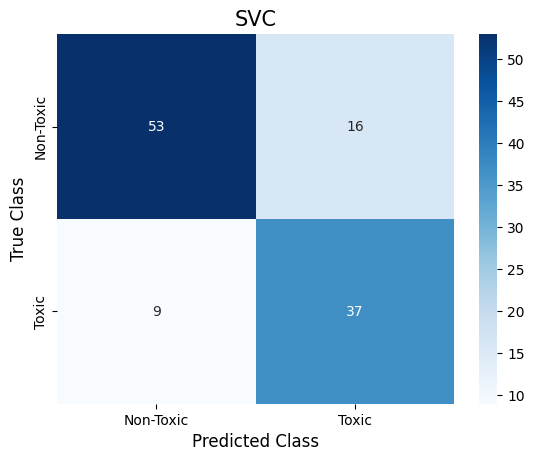

In [11]:
model_5 = SVC(
    C=best_params5["C"],
    gamma=best_params5["gamma"],
    kernel="rbf",
    probability=True,
    random_state=0,
)

ppl_5 = make_pipeline(scaler, model_5)

evaluate_model(ppl_5, X_train, y_train, X_test, y_test, kf, "SVC")

#### Decision Tree, Bayesian optimization

In [31]:
def black_box_function6(max_depth, max_features, min_samples_split, min_samples_leaf):

    model = DecisionTreeClassifier(
        max_depth=int(max_depth),
        max_features=int(max_features),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds6 = {
    "max_depth": (1, 32),
    "max_features": (1, 32),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 50),
}

optimizer6 = BayesianOptimization(
    f=black_box_function6,
    pbounds=pbounds6,
    random_state=0,
)

optimizer6.maximize(init_points=25, n_iter=75)

best_params6 = optimizer6.max["params"]

best_params6["max_depth"] = int(best_params6["max_depth"])
best_params6["max_features"] = int(best_params6["max_features"])
best_params6["min_samples_split"] = int(best_params6["min_samples_split"])
best_params6["min_samples_leaf"] = int(best_params6["min_samples_leaf"])

print(optimizer6.max)
print(best_params6)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.6422    | 18.01     | 23.17     | 30.54     | 28.15     |
| 2         | 0.6499    | 14.13     | 21.02     | 22.44     | 44.81     |
| 3         | 0.5668    | 30.87     | 12.89     | 39.79     | 27.39     |
| 4         | 0.7076    | 18.61     | 29.69     | 4.481     | 6.182     |
| 5         | 0.5148    | 1.627     | 26.81     | 39.13     | 43.76     |
| 6         | 0.6443    | 31.34     | 25.77     | 23.61     | 39.47     |
| 7         | 0.6162    | 4.667     | 20.84     | 8.024     | 47.34     |
| 8         | 0.6817    | 17.18     | 13.85     | 13.96     | 39.16     |
| 9         | 0.6854    | 15.14     | 18.62     | 1.921     | 31.65     |
| 10        | 0.6007    | 19.97     | 20.12     | 47.24     | 34.73     |
| 11        | 0.5462    | 12.14     | 14.55     | 35.18     | 4.891     |
| 12        | 0.6822    | 21.67     | 

#### Evaluation

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.7826087  0.80434783 0.84782609 0.7173913  0.84782609
 0.86956522 0.80434783 0.71111111 0.82222222] 

Decision Tree's mean result of 10-fold cross-validation is 0.799
Decision Tree's Matthews Correlation Coefficient is 0.546 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        69
           1       0.73      0.72      0.73        46

    accuracy                           0.78       115
   macro avg       0.77      0.77      0.77       115
weighted avg       0.78      0.78      0.78       115



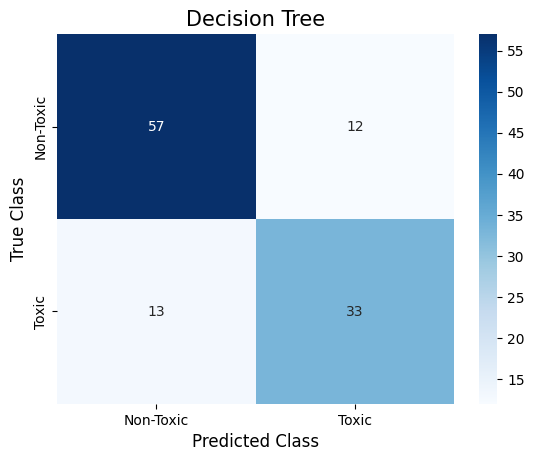

In [32]:
model_6 = DecisionTreeClassifier(
    max_depth=best_params6["max_depth"],
    max_features=best_params6["max_features"],
    min_samples_split=best_params6["min_samples_split"],
    min_samples_leaf=best_params6["min_samples_leaf"],
    random_state=0,
)

evaluate_model(model_6, X_train, y_train, X_test, y_test, kf, name="Decision Tree")

#### Bagging, Bayesian optimization

In [33]:
def black_box_function7(n_estimators, max_samples, max_features):

    model = BaggingClassifier(
        n_estimators=int(n_estimators),
        max_samples=int(max_samples),
        max_features=int(max_features),
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds7 = {"n_estimators": (50, 500), "max_samples": (1, 100), "max_features": (1, 32)}

optimizer7 = BayesianOptimization(
    f=black_box_function7, pbounds=pbounds7, verbose=2, random_state=0
)

optimizer7.maximize(init_points=25, n_iter=75)

best_params7 = optimizer7.max["params"]
best_params7["n_estimators"] = int(best_params7["n_estimators"])
best_params7["max_samples"] = int(best_params7["max_samples"])
best_params7["max_features"] = int(best_params7["max_features"])

print(optimizer7.max)
print(best_params7)

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.6769    | 18.01     | 71.8      | 321.2     |
| 2         | 0.6358    | 17.89     | 42.94     | 340.7     |
| 3         | 0.6889    | 14.57     | 89.29     | 483.6     |
| 4         | 0.6951    | 12.89     | 79.38     | 288.0     |
| 5         | 0.6937    | 18.61     | 92.63     | 81.97     |
| 6         | 0.05957   | 3.701     | 3.002     | 424.7     |
| 7         | 0.6962    | 25.12     | 87.13     | 490.4     |
| 8         | 0.6451    | 25.77     | 46.69     | 401.2     |
| 9         | 0.588     | 4.667     | 64.35     | 114.5     |
| 10        | 0.6699    | 30.28     | 52.66     | 236.6     |
| 11        | 0.6766    | 9.201     | 77.65     | 255.3     |
| 12        | 0.0       | 18.62     | 2.86      | 327.9     |
| 13        | 0.6742    | 19.97     | 62.08     | 474.7     |
| 14        | 0.6484    | 22.14     | 36.59     | 246.7     |
| 15    

#### Evaluation

Bagging's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.73913043 0.89130435 0.80434783 0.7826087  0.84782609
 0.89130435 0.76086957 0.75555556 0.73333333] 

Bagging's mean result of 10-fold cross-validation is 0.797
Bagging's Matthews Correlation Coefficient is 0.616 

Bagging's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        69
           1       0.84      0.67      0.75        46

    accuracy                           0.82       115
   macro avg       0.82      0.79      0.80       115
weighted avg       0.82      0.82      0.81       115



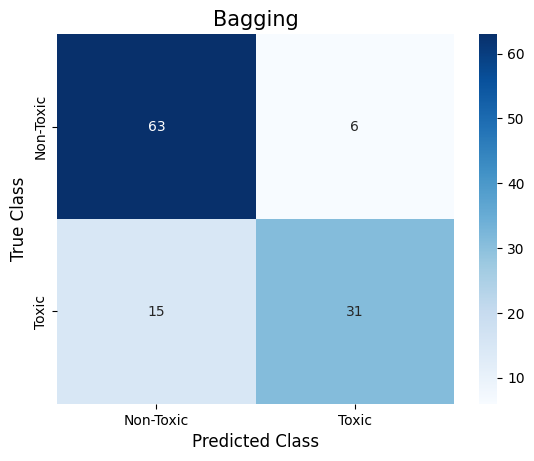

In [34]:
model_7 = BaggingClassifier(
    n_estimators=best_params7["n_estimators"],
    max_samples=best_params7["max_samples"],
    max_features=best_params7["max_features"],
    random_state=0,
)

evaluate_model(model_7, X_train, y_train, X_test, y_test, kf, "Bagging")

#### Random Forest, Bayesian optimization

In [35]:
def black_box_function8(
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
):

    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=int(max_features),
        n_jobs=-1,
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds8 = {
    "n_estimators": (50, 500),
    "max_depth": (1, 32),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 50),
    "max_features": (1, 32),
}

optimizer8 = BayesianOptimization(
    f=black_box_function8, pbounds=pbounds8, verbose=2, random_state=0
)

optimizer8.maximize(init_points=25, n_iter=75)

best_params8 = optimizer8.max["params"]
best_params8["n_estimators"] = int(best_params8["n_estimators"])
best_params8["max_depth"] = int(best_params8["max_depth"])
best_params8["min_samples_split"] = int(best_params8["min_samples_split"])
best_params8["min_samples_leaf"] = int(best_params8["min_samples_leaf"])
best_params8["max_features"] = int(best_params8["max_features"])

print("Optimized parameters:", optimizer8.max)
print(best_params8)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.6055    | 18.01     | 23.17     | 30.54     | 28.15     | 240.6     |
| 2         | 0.5797    | 21.02     | 14.57     | 44.7      | 48.26     | 222.5     |
| 3         | 0.6389    | 25.54     | 17.4      | 28.83     | 46.43     | 81.97     |
| 4         | 0.0       | 3.701     | 1.627     | 41.8      | 39.35     | 441.5     |
| 5         | 0.6105    | 31.34     | 25.77     | 23.61     | 39.47     | 103.2     |
| 6         | 0.5491    | 20.84     | 5.444     | 47.29     | 27.05     | 236.6     |
| 7         | 0.6323    | 9.201     | 25.0      | 23.35     | 29.28     | 58.46     |
| 8         | 0.625     | 20.15     | 19.97     | 31.23     | 47.3      | 356.8     |
| 9         | 0.6146    | 12.14     | 14.55     | 35.18     | 4.891     | 350.0     |
| 10        | 0.6966    | 21.79     | 7.522     | 7.31

#### Evaluation

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.73913043 0.95652174 0.80434783 0.82608696 0.84782609
 0.91304348 0.86956522 0.75555556 0.84444444] 

Random Forest's mean result of 10-fold cross-validation is 0.834
Random Forest's Matthews Correlation Coefficient is 0.672 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        69
           1       0.87      0.72      0.79        46

    accuracy                           0.84       115
   macro avg       0.85      0.82      0.83       115
weighted avg       0.85      0.84      0.84       115



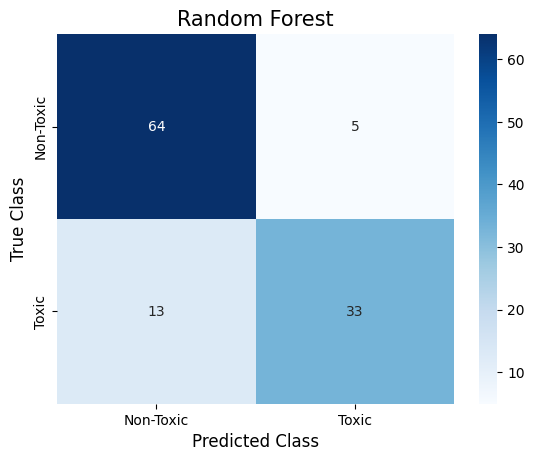

In [36]:
model_8 = RandomForestClassifier(
    n_estimators=best_params8["n_estimators"],
    max_depth=best_params8["max_depth"],
    min_samples_leaf=best_params8["min_samples_leaf"],
    min_samples_split=best_params8["min_samples_split"],
    max_features=best_params8["max_features"],
    n_jobs=-1,
    random_state=0,
)

evaluate_model(model_8, X_train, y_train, X_test, y_test, kf, "Random Forest")

#### GBDT, Bayesian optimization

In [37]:
def black_box_function9(
    n_estimators,
    learning_rate,
    max_depth,
    max_features,
    min_samples_split,
    min_samples_leaf,
    subsample,
):

    model = GradientBoostingClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        max_features=int(max_features),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        subsample=float(subsample),
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds9 = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 0.3),
    "max_depth": (1, 32),
    "max_features": (1, 32),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 50),
    "subsample": (0.1, 1),
}

optimizer9 = BayesianOptimization(
    f=black_box_function9, pbounds=pbounds9, verbose=2, random_state=0
)

optimizer9.maximize(init_points=25, n_iter=75)

best_params9 = optimizer9.max["params"]
best_params9["n_estimators"] = int(best_params9["n_estimators"])
best_params9["learning_rate"] = float("%.3g" % best_params9["learning_rate"])
best_params9["max_depth"] = int(best_params9["max_depth"])
best_params9["max_features"] = int(best_params9["max_features"])
best_params9["min_samples_split"] = int(best_params9["min_samples_split"])
best_params9["min_samples_leaf"] = int(best_params9["min_samples_leaf"])
best_params9["subsample"] = float("%.3g" % best_params9["subsample"])

print(optimizer9.max)
print(best_params9)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------


| 1         | 0.7379    | 0.1692    | 23.17     | 19.69     | 27.7      | 22.34     | 340.7     | 0.4938    |
| 2         | 0.7712    | 0.2686    | 30.87     | 12.89     | 39.79     | 27.39     | 305.6     | 0.933     |
| 3         | 0.68      | 0.0306    | 3.701     | 1.627     | 41.8      | 39.35     | 441.5     | 0.9808    |
| 4         | 0.7302    | 0.2418    | 15.31     | 25.2      | 6.795     | 32.72     | 114.5     | 0.9502    |
| 5         | 0.0       | 0.1613    | 13.85     | 9.201     | 38.94     | 23.9      | 305.8     | 0.1169    |
| 6         | 0.7351    | 0.1891    | 19.97     | 20.12     | 47.24     | 34.73     | 211.8     | 0.4933    |
| 7         | 0.7388    | 0.2123    | 2.867     | 21.67     | 33.86     | 12.1      | 108.0     | 0.3839    |
| 8         | 0.5555    | 0.1155    | 18.68     | 14.6      | 49.43     | 6.898     | 144.0     | 0.2452    |
| 9         | 0.7558    | 0.1994    | 8.852     | 15.46     | 12.98     | 9.631     | 99.67     | 0.6907    |
| 10      

#### Evaluation

GBDT's results of 10-fold cross-validation are as follows: 
 [0.80434783 0.82608696 0.89130435 0.80434783 0.80434783 0.82608696
 0.89130435 0.82608696 0.77777778 0.82222222] 

GBDT's mean result of 10-fold cross-validation is 0.827
GBDT's Matthews Correlation Coefficient is 0.56 

GBDT's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        69
           1       0.76      0.70      0.73        46

    accuracy                           0.79       115
   macro avg       0.79      0.78      0.78       115
weighted avg       0.79      0.79      0.79       115



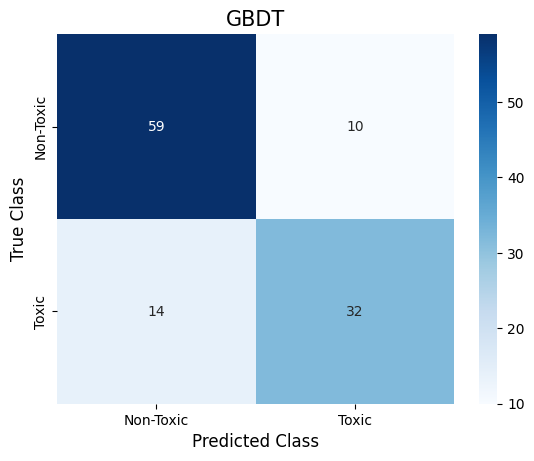

In [38]:
model_9 = GradientBoostingClassifier(
    n_estimators=best_params9["n_estimators"],
    learning_rate=best_params9["learning_rate"],
    max_depth=best_params9["max_depth"],
    max_features=best_params9["max_features"],
    min_samples_split=best_params9["min_samples_split"],
    min_samples_leaf=best_params9["min_samples_leaf"],
    subsample=best_params9["subsample"],
    random_state=0,
)

evaluate_model(model_9, X_train, y_train, X_test, y_test, kf, "GBDT")

#### LightGBM, Bayesian optimization

In [39]:
def black_box_function10(
    n_estimators,
    learning_rate,
    num_leaves,
    max_depth,
    min_child_samples,
    subsample,
    colsample_bytree,
    reg_alpha,
    reg_lambda,
):

    model = LGBMClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        num_leaves=int(num_leaves),
        min_child_samples=int(min_child_samples),
        subsample=float(subsample),
        colsample_bytree=float(colsample_bytree),
        reg_alpha=float(reg_alpha),
        reg_lambda=float(reg_lambda),
        verbose=-1,
        n_jobs=-1,
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds10 = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 0.3),
    "max_depth": (1, 32),
    "num_leaves": (2, 1024),
    "min_child_samples": (1, 50),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "reg_alpha": (0, 1),
    "reg_lambda": (0, 1),
}

optimizer10 = BayesianOptimization(
    f=black_box_function10, pbounds=pbounds10, verbose=2, random_state=0
)

optimizer10.maximize(init_points=25, n_iter=75)

best_params10 = optimizer10.max["params"]
best_params10["n_estimators"] = int(best_params10["n_estimators"])
best_params10["learning_rate"] = float("%.3g" % best_params10["learning_rate"])
best_params10["max_depth"] = int(best_params10["max_depth"])
best_params10["num_leaves"] = int(best_params10["num_leaves"])
best_params10["min_child_samples"] = int(best_params10["min_child_samples"])
best_params10["subsample"] = float("%.3g" % best_params10["subsample"])
best_params10["colsample_bytree"] = float("%.3g" % best_params10["colsample_bytree"])
best_params10["reg_alpha"] = float("%.3g" % best_params10["reg_alpha"])
best_params10["reg_lambda"] = float("%.3g" % best_params10["reg_lambda"])

print(optimizer10.max)
print(best_params10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7591    | 0.5939    | 0.2174    | 19.69     | 27.7      | 240.6     | 662.1     | 0.4376    | 0.8918    | 0.9673    |
| 2         | 0.7453    | 0.4451    | 0.2396    | 17.4      | 28.83     | 466.5     | 74.6      | 0.08713   | 0.02022   | 0.8494    |
| 3         | 0.7607    | 0.8003    | 0.2623    | 31.34     | 40.16     | 257.7     | 799.7     | 0.1183    | 0.6399    | 0.229     |
| 4         | 0.778     | 0.9502    | 0.1613    | 13.85     | 13.96     | 398.4     | 468.2     | 0.5684    | 0.01879   | 0.6559    |
| 5         | 0.7582    | 0.6509    | 0.1889    | 30.26     | 34.41     | 211.8     | 448.6     | 0.6976    | 0.06023   | 0.7001    |
| 6         | 0.763     | 0.7036    | 0.07101   | 4.997     | 

#### Evaluation

LightGBM's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.82608696 0.84782609 0.84782609 0.7826087  0.80434783
 0.86956522 0.82608696 0.75555556 0.84444444] 

LightGBM's mean result of 10-fold cross-validation is 0.819
LightGBM's Matthews Correlation Coefficient is 0.562 

LightGBM's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        69
           1       0.75      0.72      0.73        46

    accuracy                           0.79       115
   macro avg       0.78      0.78      0.78       115
weighted avg       0.79      0.79      0.79       115



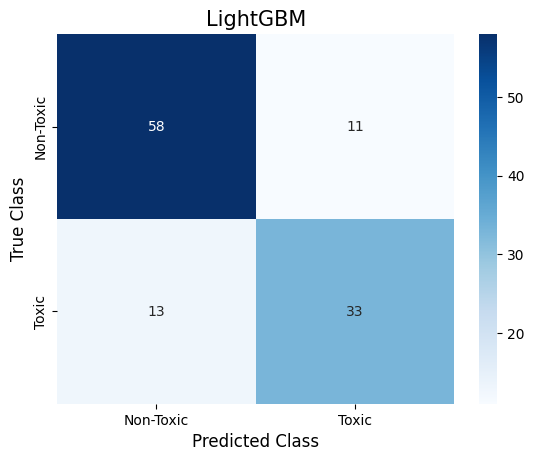

In [43]:
model_10 = LGBMClassifier(
    n_estimators=best_params10["n_estimators"],
    learning_rate=best_params10["learning_rate"],
    max_depth=best_params10["max_depth"],
    num_leaves=best_params10["num_leaves"],
    subsample=best_params10["subsample"],
    colsample_bytree=best_params10["colsample_bytree"],
    min_child_samples=best_params10["min_child_samples"],
    reg_alpha=best_params10["reg_alpha"],
    reg_lambda=best_params10["reg_lambda"],
    n_jobs=-1,
    verbosity=-1,
    random_state=0,
)

evaluate_model(model_10, X_train, y_train, X_test, y_test, kf, "LightGBM")

#### Use K-nearest Neighbor method to define the applicability domain

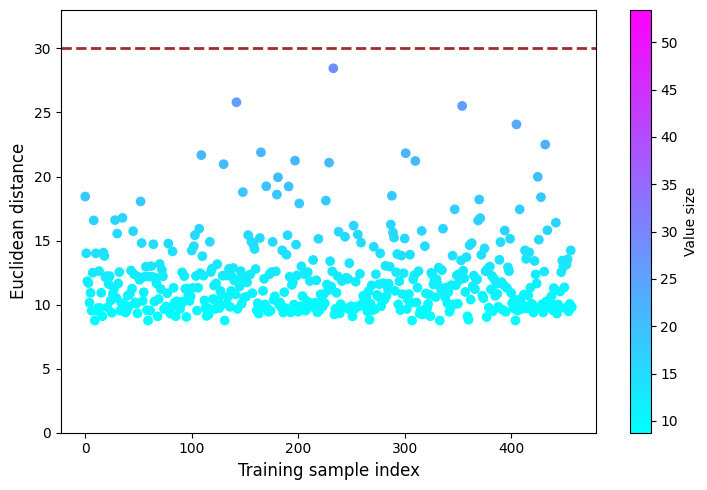

In [60]:
train_set_numeric = np.array(X_train)

dt_train_values = calculate_train_dt(train_set_numeric)

threshold = 30

plt.figure(figsize=(7.5, 5))
plt.scatter(
    range(len(dt_train_values)), dt_train_values, c=dt_train_values, cmap="cool"
)
plt.axhline(y=threshold, color="brown", linestyle="--", linewidth=2)
plt.colorbar(label="Value size")
plt.xlabel("Training sample index", fontsize=12)
plt.ylabel("Euclidean distance", fontsize=12)
plt.ylim(0, 33)
plt.tight_layout()

plt.show()

#### Observe whether the samples in the test set are contained within the applicability domain

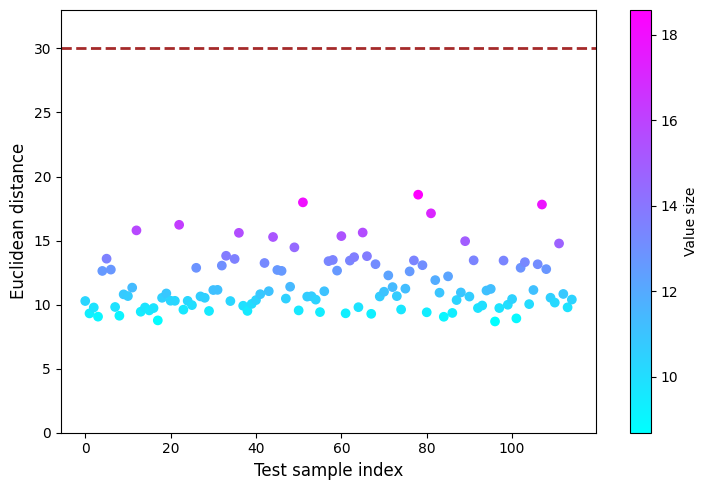

In [61]:
test_set_numeric = np.array(X_test)
dt_values_test = calculate_test_dt(test_set_numeric, train_set_numeric)

plt.figure(figsize=(7.5, 5))
plt.scatter(range(len(dt_values_test)), dt_values_test, c=dt_values_test, cmap="cool")
plt.axhline(y=threshold, color="brown", linestyle="--", linewidth=2)
plt.colorbar(label="Value size")
plt.xlabel("Test sample index", fontsize=12)
plt.ylabel("Euclidean distance", fontsize=12)
plt.ylim(0, 33)
plt.tight_layout()

plt.show()

#### Use pickle to save the models

In [46]:
clfs = [model_10, model_9, model_8, model_7, model_6, ppl_5, ppl_4, ppl_3, ppl_2, ppl_1]

clfnames = [
    "LightGBM_2class_mordred",
    "GBDT_2class_mordred",
    "RF_2class_mordred",
    "Bagging_2class_mordred",
    "DT_2class_mordred",
    "SVC_2class_mordred",
    "KNN_2class_mordred",
    "GNB_2class_mordred",
    "LDA_2class_mordred",
    "LR_2class_mordred",
]

for clf, name in zip(clfs, clfnames):
    with open(name, "wb") as f:
        pickle.dump(clf, f)

#### Use pickle to load the models

In [13]:
loaded_models = []

clfnames = [
    "LightGBM_2class_mordred",
    "GBDT_2class_mordred",
    "RF_2class_mordred",
    "Bagging_2class_mordred",
    "DT_2class_mordred",
    "SVC_2class_mordred",
    "KNN_2class_mordred",
    "GNB_2class_mordred",
    "LDA_2class_mordred",
    "LR_2class_mordred",
]

for name in clfnames:
    with open(name, "rb") as f:
        model = pickle.load(f)
        loaded_models.append(model)

#### Verify that the imported models are correct

In [14]:
modelnames = [
    "LightGBM",
    "GBDT",
    "RF",
    "Bagging",
    "DT",
    "SVC",
    "KNN",
    "GNB",
    "LDA",
    "LR",
]

df_cv_scores = {}

for model, name in zip(loaded_models, modelnames):

    y_predict = model.predict(X_test)

    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    df_cv_scores[name] = cv_scores
    acc = cv_scores.mean()
    report = classification_report(y_test, y_predict)

    print(f"{name}'s 10-fold cross-validation accuracy:\n{cv_scores}")
    print(f"\n{name}'s accuracy is {acc:.3g} (training set)")
    print(f"{name}'s classification report:\n{report}")
    print("=" * 75)

df_cv_scores = pd.DataFrame(df_cv_scores)

LightGBM's 10-fold cross-validation accuracy:
[0.7826087  0.82608696 0.84782609 0.84782609 0.7826087  0.80434783
 0.86956522 0.82608696 0.75555556 0.84444444]

LightGBM's accuracy is 0.819 (training set)
LightGBM's classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        69
           1       0.75      0.72      0.73        46

    accuracy                           0.79       115
   macro avg       0.78      0.78      0.78       115
weighted avg       0.79      0.79      0.79       115

GBDT's 10-fold cross-validation accuracy:
[0.80434783 0.82608696 0.89130435 0.80434783 0.80434783 0.82608696
 0.89130435 0.82608696 0.77777778 0.82222222]

GBDT's accuracy is 0.827 (training set)
GBDT's classification report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        69
           1       0.76      0.70      0.73        46

    accuracy                           0.79  

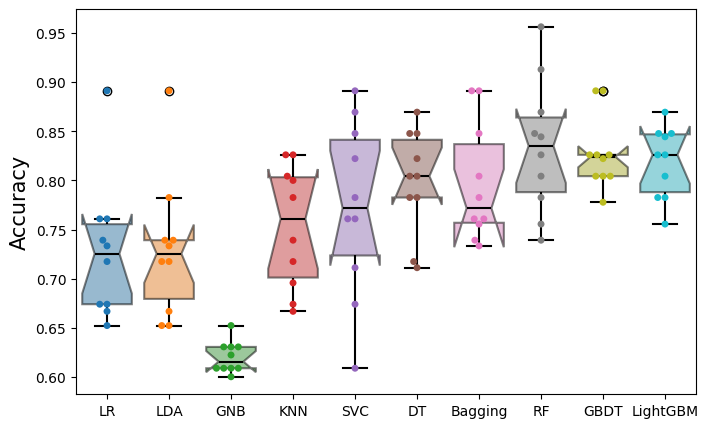

In [15]:
vars = ["LR", "LDA", "GNB", "KNN", "SVC", "DT", "Bagging", "RF", "GBDT", "LightGBM"]
df_cv_scores = df_cv_scores.melt(
    value_vars=vars, var_name="Algorithm", value_name="Accuracy"
)

plt.figure(figsize=(8, 5))

boxprops = {"alpha": 0.5}

sns.boxplot(
    df_cv_scores,
    x="Algorithm",
    y="Accuracy",
    hue="Algorithm",
    linecolor="black",
    linewidth=1.5,
    notch=True,
    boxprops=boxprops,
)
sns.swarmplot(df_cv_scores, x="Algorithm", y="Accuracy", hue="Algorithm", legend=None)

plt.xlabel("")
plt.ylabel("Accuracy", fontsize=15)

plt.show()

#### Plotting the confusion matrices for the two best models

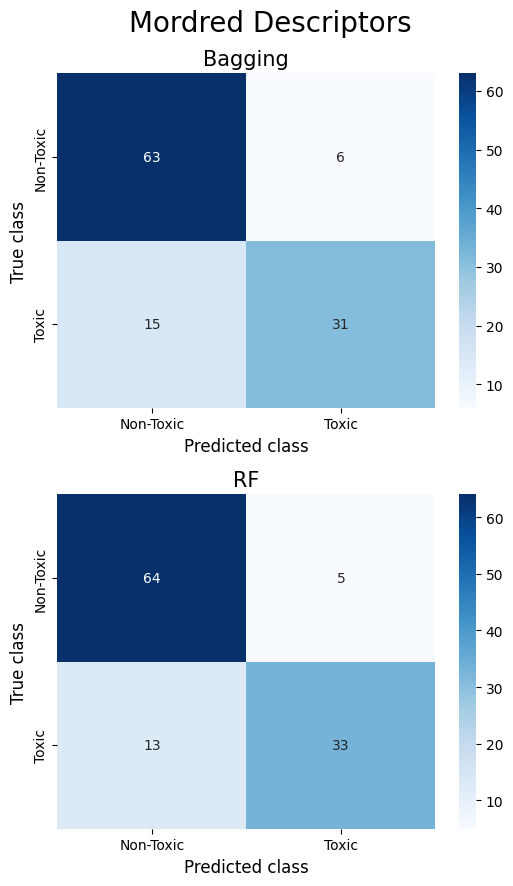

In [55]:
best_models = [loaded_models[3], loaded_models[2]]
best_modelnames = ["Bagging", "RF"]
conf_matrices = []

for model, name in zip(best_models, best_modelnames):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    classes = ["Non-Toxic", "Toxic"]
    conf_matrix = pd.DataFrame(cm, index=classes, columns=classes)
    conf_matrices.append(conf_matrix)

fig, axs = plt.subplots(2, 1, figsize=(5.5, 9))

for i, (ax, conf_matrix, modelname) in enumerate(
    zip(axs.flatten(), conf_matrices, best_modelnames)
):
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 10}, cmap="Blues", ax=ax)
    ax.set_title(modelname, fontsize=15)
    ax.set_ylabel("True class", fontsize=12)
    ax.set_xlabel("Predicted class", fontsize=12)

plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle("Mordred Descriptors", fontsize=20)
plt.tight_layout()

plt.show()

#### Plotting ROC curves for the four best models and the voting model

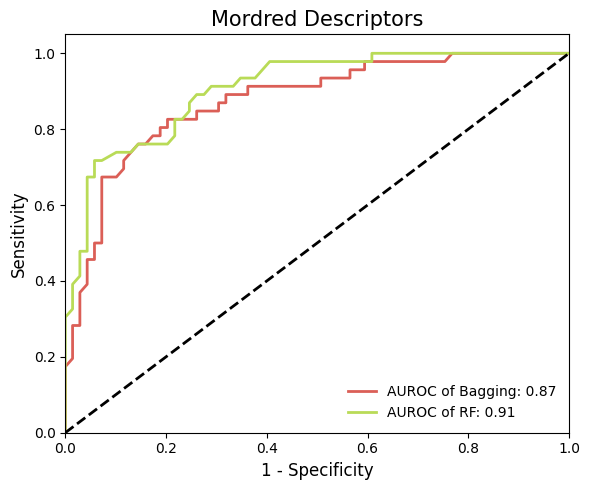

In [58]:
color_s = sns.color_palette("hls", 5)

roc_fpr, roc_tpr, roc_labels = [], [], []
pr_recall, pr_precision, pr_labels = [], [], []

plt.figure(figsize=(6, 5))

for model, color, name in zip(best_models, color_s, best_modelnames):
    y_proba = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    plt.plot(fpr, tpr, lw=2, label=f"AUROC of {name}: {roc_auc:.2g}", color=color)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Mordred Descriptors", fontsize=15)
plt.xlabel("1 - Specificity", fontsize=12)
plt.ylabel("Sensitivity", fontsize=12)
plt.legend(loc="best", frameon=False, prop={"size": 10})

plt.tight_layout()
plt.show()